## Семинар 7: "Методы оптимизации"

ФИО: Калашников Дмитрий Павлович

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

### <i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [413]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters:      
            param.grad.data.zero_()
  
    def step(self, F):
        loss = F()
        loss.backward()

        
class SGD(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for param in self.parameters:
                param -= self.learning_rate * param.grad
            self.zero_grad()
                
                
class Momentum(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v
            self.zero_grad()
                
                
class NAG(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.gamma = gamma
    
    def step(self, F):
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param -= v * self.gamma
        
        super().step(F)
        
        with torch.no_grad(): 
            for v, param in zip(self.v, self.parameters):
                param += v * self.gamma
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v
            self.zero_grad()
                

class RMSProp(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate * 10
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-8
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad
            self.zero_grad()
                

class AdaGrad(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-8
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_( param.grad ** 2 )
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad
            self.zero_grad()
                

class AdaDelta(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.delta = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 1e-8
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for g, delta, param in zip(self.G, self.delta, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                cur_delta = torch.sqrt(delta + self.eps) / torch.sqrt(g + self.eps) * param.grad
                param -= cur_delta
                delta.copy_(self.gamma * delta + (1 - self.gamma) * cur_delta ** 2)
            self.zero_grad()
                
                
class Adam(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma = 0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.b1 = 0.9
        self.b2 = 0.999
        self.step_number = 1
        self.m_t = [torch.zeros_like(param) for param in self.parameters]
        self.v_t = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma
        self.eps = 1e-8
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for m_t, v_t, param in zip(self.m_t, self.v_t, self.parameters):

                m_t.copy_( self.b1 * m_t + (1 - self.b1) * param.grad )
                v_t.copy_( self.b2 * v_t + (1 - self.b2) * param.grad ** 2 )
                
                m_t_shift = m_t / (1 - self.b1 ** self.step_number)
                v_t_shift = v_t / (1 - self.b2 ** self.step_number)
                
                param -= self.learning_rate / (torch.sqrt(v_t) + self.eps) * m_t
                
            self.step_number += 1 
            self.zero_grad()

In [414]:
x_0 = np.array([2.5, 1.5]).reshape(1, -1)
optimizers = [SGD, Momentum, NAG, RMSProp, AdaGrad, AdaDelta, Adam]
names = []
for optim in optimizers:
    names.append(optim.__name__)
learning_rates = [0.00365, 0.0008, 0.00001, 0.0013, 0.001, 0.01, 0.01] 

In [415]:
def F(x):
    x, y = x[:, 0], x[:, 1]
    
    return torch.sin(x) * x**2 * y + torch.cos(y ** 2) * y**2

In [416]:
def has_converged(func, eps, x_prev, x):
    with torch.no_grad():
        return torch.abs( (func( x ) - func( x_prev )) ).item() < eps

In [417]:
def get_points(x_0, func):
    optim_path = []

    for optim, lr in zip(optimizers, learning_rates):
        print(optim.__name__)
        
        x_prev = torch.tensor(x_0, requires_grad=False)
        x = torch.tensor(x_0, requires_grad=True)
        optim = optim([x], learning_rate=lr)

        points = []

        i = 0
        while ( True ):
            i += 1
            p_z = func(x).item()
            p_x, p_y = x.detach().numpy().flatten()
            
            points.append((p_x, p_y, p_z))

            optim.step(lambda: func(x))
            optim.zero_grad()
            
            if has_converged(func, 1e-4, x_prev, x):
                print(p_z, p_x, p_y, 'steps:', i)
                break
            
            x_prev.copy_(x)
            
        optim_path.append(points)

    return optim_path

In [418]:
optim_path = get_points(x_0, F)

SGD
-84.57997408712832 5.086985033780046 3.148955800055507 steps: 93
Momentum
-135.21431959561477 5.087296920767426 4.705970185553652 steps: 179
NAG
-52.47119245521326 5.084657542292162 2.270264393132092 steps: 2180
RMSProp
-84.57984440779417 5.08698509410094 3.1484846898563994 steps: 224
AdaGrad
-84.5799244861837 5.0861719831168095 3.14886272928905 steps: 3203
AdaDelta
-84.57968741200237 5.08698509410227 3.14812611261346 steps: 1357
Adam
-84.57593966909005 5.085372355814291 3.1449299289323394 steps: 132


In [419]:
R = 2
N = 21

space = np.linspace(R, -R, N)
X, Y = np.meshgrid(space, space)

Z = F(torch.tensor([X.flatten(), Y.flatten()]).T).reshape(N, N)

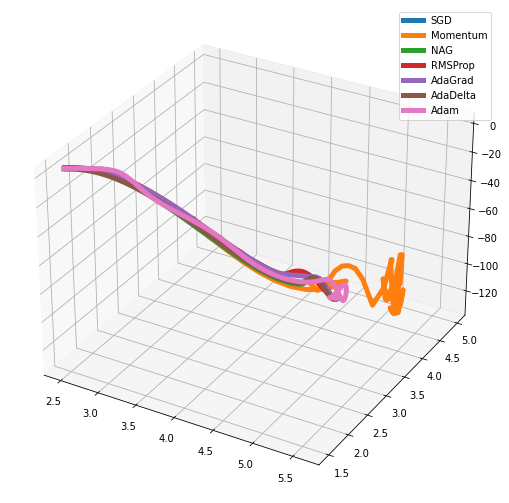

In [420]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

for name, path in zip(names, optim_path):
    points = np.array(path)
    points += np.random.rand(3) * 0.04
    ax.plot(points[:, 0], points[:, 1], points[:, 2], linewidth=5, label=name)

"""
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
"""

plt.legend()

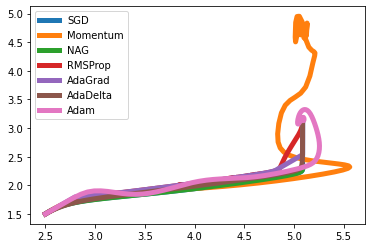

In [421]:
for name, path in zip(names, optim_path):
    points = np.array(path)        
    plt.plot(points[:, 0], points[:, 1], label=name, linewidth=5)
plt.legend()

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [422]:
f2 = lambda X: X[:, 0] ** 2 + X[:, 1] ** 2

In [423]:
optim_path = get_points(x_0, f2)

SGD
0.006863350728246122 0.07103929488549295 0.04262357693129587 steps: 487
Momentum
0.0025386101944545724 0.043204457443431724 0.02592267446605905 steps: 220
NAG
0.24957308675512407 0.4283802313530132 0.25702813881180986 steps: 8815
RMSProp
0.00037842483094979116 0.01945309213099249 4.5138596669328204e-05 steps: 218
AdaGrad
0.002500249251687395 0.050000242516285806 0.00047434164902525615 steps: 2451
AdaDelta
0.012249177724325724 0.11067600338070455 -1.358833237718192e-31 steps: 3134
Adam
0.0005403176042939428 0.02221530211251925 0.006840903181849644 steps: 86


<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [424]:
f3 = lambda X: X[:, 0] ** 2 * torch.sin(X[:, 0]) + X[:, 1] ** 2 * torch.cos(X[:, 1])

In [425]:
optim_path = get_points(x_0, f3)

SGD
-35.72001817495629 5.086954059997567 3.6340286658041756 steps: 153
Momentum
-35.719348741132734 5.082135326273201 3.6322071643257305 steps: 119
NAG
3.8996096044020594 2.5 1.5 steps: 1
RMSProp
-35.720601132557015 5.083420658177829 3.643597167425401 steps: 205
AdaGrad
-35.720655465261885 5.083999981619821 3.6440693563002506 steps: 2585
AdaDelta
-35.71664003821053 5.08730068923406 3.6213628783131373 steps: 1631
Adam
-35.69922564306885 5.0545633713487765 3.616630030831317 steps: 80


<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [426]:
f4 = lambda X: X[:, 0] ** 2 * torch.sin(X[:, 0] ** 2) + X[:, 1] ** 2 * torch.cos(X[:, 1] ** 2)

In [427]:
optim_path = get_points(x_0, f4)

SGD
-8.102606339601149 2.2165699318993966 1.847852513498019 steps: 29
Momentum
-8.0907402350003 2.2190449022846424 1.871737161505002 steps: 51
NAG
-8.09337782311485 2.216631261102695 1.8316827932650472 steps: 728
RMSProp
-8.10270961443952 2.2180458261824914 1.8499744826418762 steps: 35
AdaGrad
-8.102742430655345 2.21700036524335 1.8489999920458895 steps: 350
AdaDelta
-8.101116664807003 2.2208967752340407 1.8454529272389202 steps: 743
Adam
-8.053187335433307 2.186030421806923 1.8621271597752458 steps: 41


###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

In [36]:
transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

#### Train-функция

In [66]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [409]:
def train(network, epochs, optimizer):
    loss = nn.NLLLoss()
    
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                
                loss_batch = lambda: loss(prediction, y)
                with torch.no_grad():
                    losses.append( loss_batch().item() )
                
                optimizer.step( loss_batch )
                
                optimizer.zero_grad()
                
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
                
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
                
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            
            
            plt.figure(figsize=(14,5))
            plt.subplot(1, 2, 1)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
            
    except KeyboardInterrupt:
        pass

#### Полносвязный слой

In [410]:
def linear_run(opt, lr=0.001):
    network = nn.Sequential(nn.Flatten(), nn.Linear(28 * 28 * 1, 100), nn.Sigmoid(),
                                       nn.Linear(100, 100), nn.Sigmoid(),
                                       nn.Linear(100, 10), nn.LogSoftmax(dim=1))
    
    optimizer =  opt(network.parameters(), learning_rate=lr)
    train(network, 5, optimizer)

Epoch 4... (Train/Test) NLL: 2.236/2.222	Accuracy: 0.312/0.365


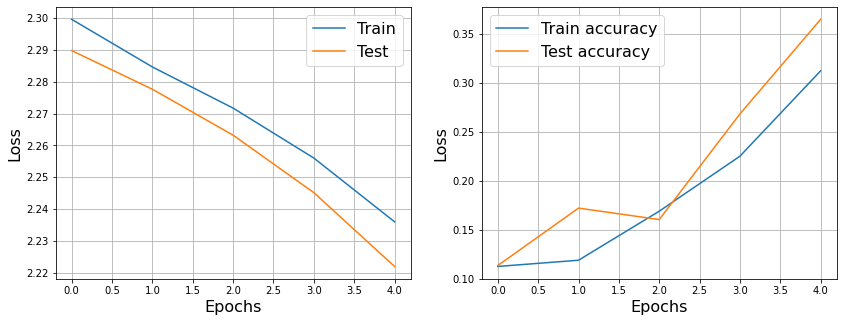

In [369]:
linear_run(SGD)

Epoch 4... (Train/Test) NLL: 0.157/0.217	Accuracy: 0.968/0.962


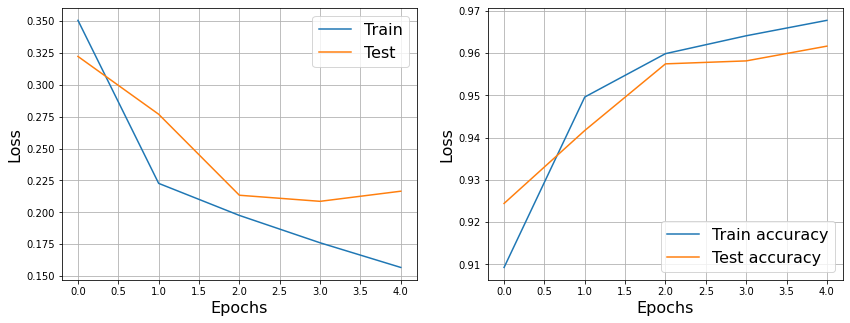

In [370]:
linear_run(AdaGrad, 0.01)

Epoch 4... (Train/Test) NLL: 0.157/0.155	Accuracy: 0.954/0.954


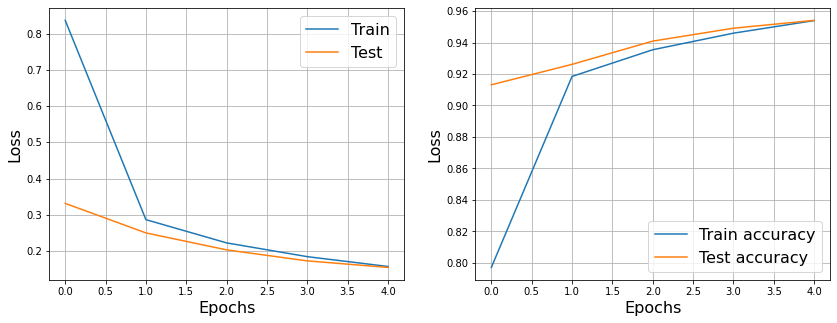

In [371]:
linear_run(AdaDelta, 0.001)

Epoch 4... (Train/Test) NLL: 0.058/0.096	Accuracy: 0.982/0.971


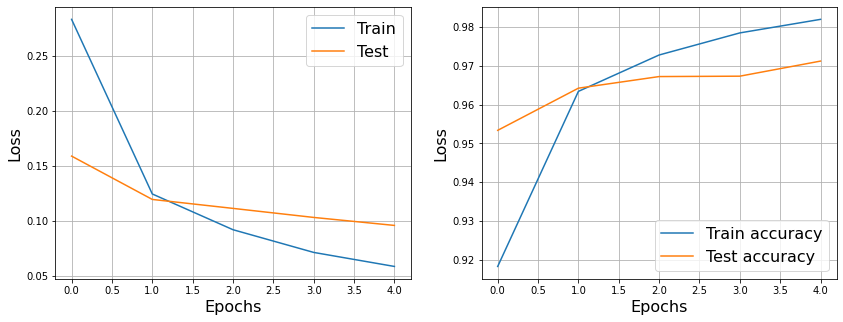

In [411]:
linear_run(Adam, 0.001)

#### Свёрточный слой

In [373]:
def conv_run(opt, lr=0.01):
    network = nn.Sequential(nn.Conv2d(1, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                        nn.Conv2d(3, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                        nn.Conv2d(8, 16, 3, padding=1),
                        nn.Flatten(),
                        nn.Linear(7 * 7 * 16, 10),
                        nn.LogSoftmax(dim=1))
    
    optimizer = opt(network.parameters(), learning_rate=lr)
    train(network, 5, optimizer)

Epoch 4... (Train/Test) NLL: 0.089/0.075	Accuracy: 0.972/0.977


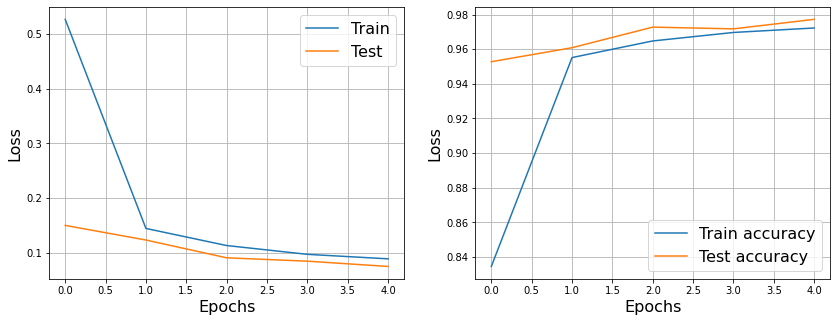

In [374]:
conv_run(SGD)

Epoch 4... (Train/Test) NLL: 0.377/0.267	Accuracy: 0.949/0.963


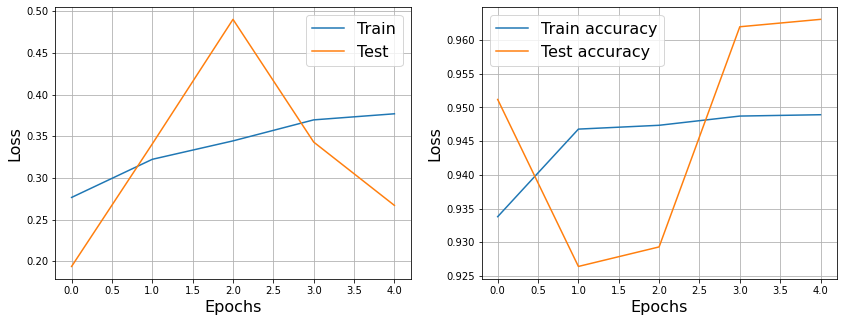

In [375]:
conv_run(AdaGrad)

Epoch 4... (Train/Test) NLL: 0.090/0.075	Accuracy: 0.972/0.976


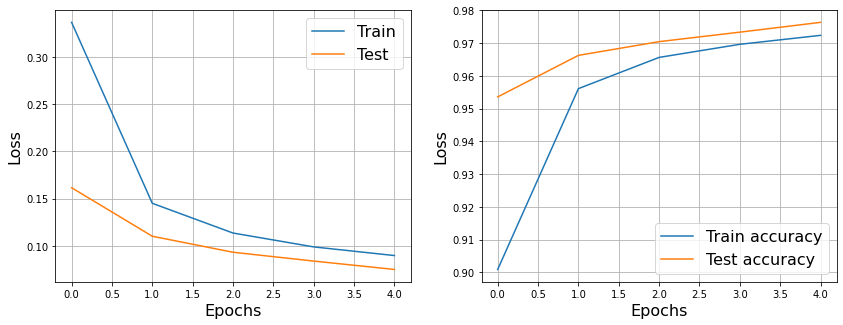

In [376]:
conv_run(AdaDelta)

Epoch 4... (Train/Test) NLL: 0.058/0.052	Accuracy: 0.982/0.982


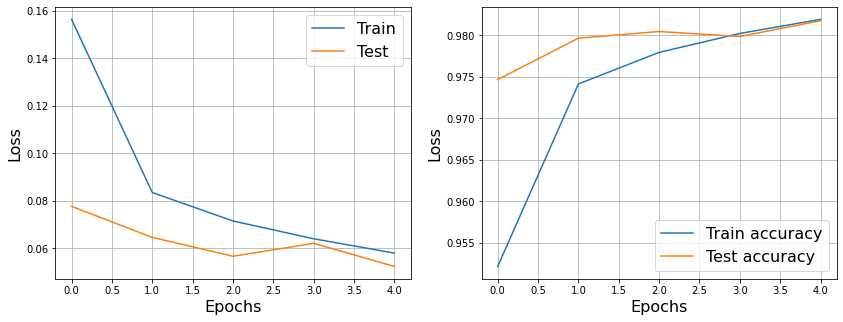

In [412]:
conv_run(Adam, 0.001)